# How to Measure the Strength of Ties between Nodes?

# Introduction

This tutorial explores different methods to measure the connectedness and strength of social ties.  Often times, we can observe social ties based on if people are friends with each other on popular social or professional networks such as Facebook or LinkedIn.  However, people sometimes join the same network out of peer-pressure or reciprocation, so whether they are "friends" on social media may not be the most accurate representation of social ties.  In other instances, we may not have access to social media data that help define people’s connections.  In these circumstances, we can measure the connections between people based on common events they attended together.  

In our previous Graph Library homework, we explored connecting vertices, or nodes, in a graph using adjacency matrix.  Each edge, which is the line segment that connects two vertices in the graph, is weighted as one.  However, not all ties should be considered equally.  For instance, if one node is connected to many other nodes, the strength of its connection should perhaps be weighted less than the strength of connections from a node that are connected to only a few other nodes.  The intuition is that in real life, if an individual is friends with a hundred people, the connection may not be as special as the connection with an individual who only has a few cherished friendships.    

There are many applications for measuring the strength of social ties.  We can understand social cohorts behaviors better, and build recommender systems based on the preferences of other individuals in the group who hold strong social ties.  Within an organization, we can understand and predict the performance of employees based on the people they have strong connections with.  Perhaps strong performers in an organization can bring up the performance of people they frequently interact with, and weak performers bring down the group as a whole.  All of these hypotheses can be tested if we can measure the connectedness and strength of social ties.  In addition, given two nodes that currently have no association, we may be able to predict the likelihood of a future connection between them. 

# Tutorial Content

This tutorial will introduce a few metrics to measure the strength between social ties.  Each metric will then be evaluated on whether they meet the conditions of eight axioms.  We will first create a method to add edges.  Unlike the add_edges() method we implemented in the previous Graph Library homework, the setup for this tutorial will be slightly different.  Here is a toy example.  In our graph, we will have people and events.  The nodes in circles on the left represent people, while the nodes on the right in squares represent events.  The line between the circle and square nodes represent the events they people attended. 

![title](graph.PNG)

Given the bipartite graph of person X event, we can use different metrics to infer tie strength.  As we go, below are the sections we will cover.  At the end, we will also plot a sample network graph of William Shakespeare's _the Tempest_ using the algorithms we have constructed.  

* [Function Setup and Metric I: Common Neighbors](#setup)

* [Metric II: Jaccard Index](#jaccard)

* [Metric III: Delta](#delta)

* [Metric IV and V: Adamic and Adar, and Linear](#adamic)

* [Metric VI: Preferential Attachment](#preferential)

* [Metrics Evaluation using Axioms](#axioms)

* [Exploring the Network Graph in _the Tempest_](#tempest)

<a id='setup'></a>
# Function Setup and Metric I: Common Neighbors

In [1]:
import numpy as np
import collections
import itertools

In [92]:
class Graph:
    def __init__(self):
        """ Initialize the class. """
        self.events = {} # key is event, value is the list of people who attended the event
        
        self.edges = {}  # this is a dictionary with keys as a pair of nodes and value as number of 
                         # mutual events they attended together
            
        self.people = []  # a list of all nodes, or people
        
        self.ppl_events = {} # key is a node, or a person, value is the number of all the events the person
                            # attended
            
        self.edges_events = {}  # a dictionary with keys as a pair of nodes and value as a list of common
                                # events the pair of people attended together
    
    def add_edges(self, events, people):
        """ Add edges to the network. 
        
        Args:
            events: a dictionary where key is event, value is the list of people who attended the event
            people: a list of all people who are in this graph
            
        """
        self.events = events
        self.people = sorted(people)
        for person in self.people:  # initialize the dictionary
            self.ppl_events[person] = 0
        all_combo = list(itertools.combinations(self.people, 2)) # get all unique combinations of a pair of nodes
        for i in all_combo:        
            self.edges[i] = 0     #initalize the dictionary
            self.edges_events[i] = []
        for event in self.events:  
            list_att = self.events[event] # list of people who attended event
            for j in list_att:
                self.ppl_events[j] += 1  #increment the event count for everyone who is in the event
            for pair in all_combo:
                if pair[0] in list_att and pair[1] in list_att:
                    self.edges[pair] += 1  #increment the event count for the pair of nodes
                    self.edges_events[pair].append(event)   #add the event to the list of events for the pair 
        

                 
# test code with our toy example
test_events = {'P': ['a', 'b'], 'Q': ['b', 'c', 'd'], 'R': ['c', 'd', 'e']}
test_people = ['a', 'b', 'c', 'd', 'e']
G = Graph()
G.add_edges(test_events, test_people)
print G.ppl_events
print G.edges
print G.edges_events

{'a': 1, 'c': 2, 'b': 2, 'e': 1, 'd': 2}
{('b', 'c'): 1, ('c', 'd'): 2, ('d', 'e'): 1, ('c', 'e'): 1, ('a', 'd'): 0, ('a', 'e'): 0, ('a', 'b'): 1, ('b', 'e'): 0, ('a', 'c'): 0, ('b', 'd'): 1}
{('b', 'c'): ['Q'], ('c', 'd'): ['Q', 'R'], ('d', 'e'): ['R'], ('c', 'e'): ['R'], ('a', 'd'): [], ('a', 'e'): [], ('a', 'b'): ['P'], ('b', 'e'): [], ('a', 'c'): [], ('b', 'd'): ['Q']}


Now we have created the edges in the graph, let’s start with some of the basic metrics to analyze strength of connections between nodes.  

The first one is Common Neighbors, which is just the number of common events individual u and individual v attended.  Formally, Common Neighbors tie strength between individual u and v is defiend as $TS(u, v) = |E(u) \cap E(v)|$, E(u) and E(v) represents the events u attended and v attended respectively (or the neighborhood v and u are in from the Person X Event graph). Our add_edges method satisfies the Common Neighbors already. 

<a id='jaccard'></a>
# Metric II: Jaccard Index

The second method is Jaccard Index, which takes into consideration of how “social” individual u and v are.  In other words, this metric solves the problem that two nodes could have many common neighbors solely because they have lots of neighbors, not because they have strong ties.  The strength of ties is defined as the total number of events u and v both attended (intersection) divided by the union of events u and v attended. Formally, it is $TS(u,v)=\frac{|E(u) \cap E(v)|}{|E(u) \cup E(v)|}$

In [93]:
def jaccard_index (edges, ppl_events):
    """Returns: the dictionary of tie strength calculated based on Jaccard Index"""
    dict_jaccard = collections.OrderedDict()
    for pair in edges:
        dict_jaccard[pair] = float(edges[pair])/ \
        float(ppl_events[pair[0]] + ppl_events[pair[1]])
    return dict_jaccard
                 
# test code with our toy example
print jaccard_index(G.edges, G.ppl_events)

OrderedDict([(('b', 'c'), 0.25), (('c', 'd'), 0.5), (('d', 'e'), 0.3333333333333333), (('c', 'e'), 0.3333333333333333), (('a', 'd'), 0.0), (('a', 'e'), 0.0), (('a', 'b'), 0.3333333333333333), (('b', 'e'), 0.0), (('a', 'c'), 0.0), (('b', 'd'), 0.25)])


<a id='delta'></a>
# Metric III: Delta

Delta is a measure of tie strength where the strength increases with the number of events.  It is formally defined as TS(u,v) = $\sum_{P\in E(u) \cap E(v)} \frac{1}{| P | \choose 2}$, where the number of people that attended event P can be denoted as |P|.  If |P| is small, then $| P | \choose 2$ is smaller and the fraction of a smaller number leads to a larger result.  This metric mactches our intuition that two people are more likely to meet or be introduced at a smaller event.

In [94]:
def delta (edges_events, events):
    """Returns: the dictionary of tie strength calculated based on Delta"""
        
    dict_delta = collections.OrderedDict()
    for pair in edges_events:
        list_delta = []
        for event in edges_events[pair]:
            list_delta.append(len(events[event]))
        #print list_delta
        if len(list_delta) == 0: # no common events
            dict_delta[pair] = 0.0
        else:
            list_perm = []
            for h in list_delta:
                dummy_perm = range(h)
                #print pair
                #print dummy_perm
                list_perm.append(len(list(itertools.combinations(dummy_perm, 2))))
            #print list_perm

            dict_delta[pair] = np.sum(1/np.array(list_perm).astype(float))
                
    return dict_delta
                 
# test code with our toy example
print delta(G.edges_events, G.events)

OrderedDict([(('b', 'c'), 0.33333333333333331), (('c', 'd'), 0.66666666666666663), (('d', 'e'), 0.33333333333333331), (('c', 'e'), 0.33333333333333331), (('a', 'd'), 0.0), (('a', 'e'), 0.0), (('a', 'b'), 1.0), (('b', 'e'), 0.0), (('a', 'c'), 0.0), (('b', 'd'), 0.33333333333333331)])


# <a id='adamic'></a>
# Metric IV and V: Adamic and Adar, and Linear

Adamic and Adar is sometimes also referred to as Frequency-Weighted Common Neighbors.  This metric refines the simple counting of neighbors by weighting rare events more heavily.  Similar to Delta, this metric is also built upon the intuition that two people are more likely to meet or be introduced at a smaller event.  Adamic and Adar is formally defined as $\sum_{P\in E(u) \cap E(v)} \frac{1}{log|P|}$, where |P| again represents the number of people in event P.

Linear is also a slight variation from Delta and Adamic and Adar.  Linear is defined as $\sum_{P\in E(u) \cap E(v)} \frac{1}{|P|}$.

In [95]:
def adamic_adar(edges_events, events):
    """Returns: the dictionary of tie strength calculated based on Adamic and Adar"""
    dict_ada = collections.OrderedDict()
    for pair in edges_events:
        list_ada = []
        for event in edges_events[pair]:
            list_ada.append(len(events[event]))
        if len(list_ada) == 0: # no common events
            dict_ada[pair] = 0.0
        else:
            dict_ada[pair] = np.sum(1/np.log(np.array(list_ada)))
    return dict_ada

def linear(edges_events, events):
    """Returns: the dictionary of tie strength calculated based on Linear"""
    dict_linear = collections.OrderedDict()
    for pair in edges_events:
        list_linear = []
        for event in edges_events[pair]:
            list_linear.append(len(events[event]))
        if len(list_linear) == 0: # no common events
            dict_linear[pair] = 0.0
        else:
            #print list_linear
            dict_linear[pair] = np.sum(1/(np.array(list_linear)).astype(float))
    return dict_linear
                 
# test code with our toy example
print adamic_adar(G.edges_events, G.events)
print linear(G.edges_events, G.events)

OrderedDict([(('b', 'c'), 0.91023922662683732), (('c', 'd'), 1.8204784532536746), (('d', 'e'), 0.91023922662683732), (('c', 'e'), 0.91023922662683732), (('a', 'd'), 0.0), (('a', 'e'), 0.0), (('a', 'b'), 1.4426950408889634), (('b', 'e'), 0.0), (('a', 'c'), 0.0), (('b', 'd'), 0.91023922662683732)])
OrderedDict([(('b', 'c'), 0.33333333333333331), (('c', 'd'), 0.66666666666666663), (('d', 'e'), 0.33333333333333331), (('c', 'e'), 0.33333333333333331), (('a', 'd'), 0.0), (('a', 'e'), 0.0), (('a', 'b'), 0.5), (('b', 'e'), 0.0), (('a', 'c'), 0.0), (('b', 'd'), 0.33333333333333331)])


<a id='preferential'></a>
# Metric VI: Preferential Attachment

Preferential Attachment is a popular concept in social networks that people with many connections tend to create more connections in the future as well.  A crude way of interpreting this is the popular belief that the rich tend to hang out with the rich and get richer.  In our problem setup, we interpret this as the more events a person attend, the more neighborhoods the person is involved in and the stronger the person’s ties are.  This is clearly not always the case in real life, which I will go into more details at the next section when we talk about the intuition for the axioms and whether the metrics meet the axioms.  For now, let’s formally define Preferential Attachment as TS(u,v) = |E(u)| * |E(v)|.

In [96]:
def preferential(edges, ppl_events):
    """Returns: the dictionary of tie strength calculated based on Preferential Attachment"""
    dict_pref = collections.OrderedDict()
    for pair in edges:
        dict_pref[pair] = float(ppl_events[pair[0]]) * float(ppl_events[pair[1]])
    return dict_pref
                 
# test code with our toy example
print preferential(G.edges, G.ppl_events)

OrderedDict([(('b', 'c'), 4.0), (('c', 'd'), 4.0), (('d', 'e'), 2.0), (('c', 'e'), 2.0), (('a', 'd'), 2.0), (('a', 'e'), 1.0), (('a', 'b'), 2.0), (('b', 'e'), 2.0), (('a', 'c'), 2.0), (('b', 'd'), 4.0)])


<a id='axioms'></a>
# Metrics Evaluation using Axioms

Now that we have defined the metrics, we will discuss some of the axioms and the intuitions that we hope the tie strength metrics would satisfy.

Axiom 1: Isomorphism.
Intuition: tie strength between u and v should not depend on the labels of u and v, but only on the link structure.

Axiom 2: baseline.
Intuition: if there are no events, i.e. the graph is empty, then the tie strength between every pair u and v should be 0.  If there are only two people u and v and a single event which u and v attend, then tie strength is 1.

Axiom 3: frequency (more events create stronger ties). 
Intuition: all other things being equal, the more common events u and v attend, the stronger their tie strength.

Axiom 4: intimacy (smaller events create stronger ties).
Intuition: all else being equal, the fewer attendees there are to an event, the stronger the tie between a pair of attendees to this event.

Axiom 5: popularity (larger events create more ties).
Intuition: if event P has more attendees than event Q, then the TOTAL tie strength created by P is more than that created by Q.

Axiom 6: conditional independence of vertices.
Intuition: the tie strength of u to other people does not depend on events that u does not attend; it only depends on the events that u attends.

Axiom 7: conditional independence of events. 
Intuition: the increase in tie strength between two people u and v due to an event P does not depends on other events, but only on existing tie strength between u and v.

Axiom 8: submodularity.
Intuition: the marginal increase in tie strength of u and v due to an event P is at most the tie strength between u and v if Q was their only event.

How do the metrics we introduced earlier meet these axioms?


![title](table.PNG)

We can see that most of our metrics meet all of the intuitions we hope the measurement of tie strength would satisfy.  Some of the metrics, namely Jaccard Index and Preferential Attachment, do not satisfy all of the axioms.  It makes sense that Jaccard Index does not satisfy Axiom 6, 7 and 8, as the metric depends on not only the events u and v both attend, but also the events that u and v attended separately.  Preferential Attachment failed Axiom 3 because regardless of the number of common events u and v attend, as long as u and v attend sufficient number of events, even if they never cross path, they will have a higher tie strength.  However, it does not indicate that Jaccard Index and Preferential Attachment should not be used when evaluating tie strength.  Preferential Attachment, for instance, is a popular metric for link predictions in social networks.  It follows the assumption that users with many friends tend to create more connections in the future.  Therefore, we should choose metrics according to which aspect of the problem we want to address.  For one of my other course project, we used Jaccard Index to measure the strength of ties between company employees and use the measured tie strength to test if high performers tend to connect more with other high performers, and if low performers tend to be around other low performers.  We decided to use Jaccard Index because it takes into consideration of how “social” people are, or in an organization setting, how many meetings or events people tend to be in due to job requirement.

Due to the confidentiality of the organization data I was working with, I will not be demonstrating my analysis from the organization data.  However, in the next section, we will use Shakespeare’s _the Tempest_ to test out our metrics.


<a id='tempest'></a>
# Exploring the Network Graph in _the Tempest_

In [97]:
# test code with the Tempest
# a1s1 stands for Act I Scene I etc.
tempest_events = {'a1s1': ['Mariners', 'Alonso', 'King of Naples', 'Sebastian', 'Antonio', 'Gonzalo', 'Boatswain', \
                           'Ferdinand', 'Francisco', 'Trinculo', 'Stephano'], \
                  'a1s2': ['Prospero', 'Miranda', 'Ariel','Caliban', 'Ferdinand'], \
                  'a2s1': ['Alonso', 'Sebastian', 'Antonio', 'Gonzalo', 'Francisco', 'Ariel'],\
                  'a2s2': ['Caliban', 'Trinculo', 'Stephano'],\
                  'a3s1': ['Ferdinand', 'Miranda', 'Prospero'], \
                  'a3s2': ['Caliban', 'Trinculo', 'Stephano', 'Ariel'], \
                  'a3s3': ['Alonso', 'Sebastian', 'Antonio', 'Gonzalo', 'Prospero', 'Ariel'], \
                  'a4s1': ['Prospero', 'Ferdinand', 'Miranda', 'Ariel', 'Iris', 'Juno', 'Ceres', 'Caliban', 'Trinculo',\
                           'Stephano'], \
                  'a4s2': ['Prospero', 'Ariel', 'Alonso', 'Antonio', 'Sebastian', 'Gonzalo', 'Ferdinand', 'Miranda', \
                           'Boatswain', 'Mariners', 'Caliban', 'Trinculo', 'Stephano']}
tempest_people = ['Mariners', 'Alonso', 'King of Naples', 'Sebastian', 'Antonio', 'Gonzalo', 'Boatswain', \
                 'Prospero', 'Miranda', 'Ariel', 'Caliban', 'Ferdinand', 'Francisco', 'Trinculo', 'Stephano',\
                 'Iris', 'Juno', 'Ceres']
G_t = Graph()
G_t.add_edges(tempest_events, tempest_people)
print 'ppl_events: ', G_t.ppl_events
print 'edges: ', G_t.edges
print 'edges_events: ', G_t.edges_events

ppl_events:  {'Iris': 1, 'Ceres': 1, 'Prospero': 5, 'Juno': 1, 'Alonso': 4, 'Caliban': 5, 'Antonio': 4, 'Ariel': 6, 'Sebastian': 4, 'Francisco': 2, 'King of Naples': 1, 'Miranda': 4, 'Boatswain': 2, 'Ferdinand': 5, 'Mariners': 2, 'Trinculo': 5, 'Gonzalo': 4, 'Stephano': 5}
edges:  {('Francisco', 'Mariners'): 1, ('Boatswain', 'Caliban'): 1, ('Alonso', 'Miranda'): 1, ('Alonso', 'Iris'): 0, ('Mariners', 'Stephano'): 2, ('King of Naples', 'Miranda'): 0, ('Prospero', 'Stephano'): 2, ('Boatswain', 'Iris'): 0, ('Alonso', 'Trinculo'): 2, ('Boatswain', 'Prospero'): 1, ('Alonso', 'Antonio'): 4, ('Alonso', 'Ceres'): 0, ('Mariners', 'Miranda'): 1, ('Ceres', 'Stephano'): 1, ('Mariners', 'Prospero'): 1, ('Ceres', 'Miranda'): 1, ('Alonso', 'Gonzalo'): 4, ('Ferdinand', 'King of Naples'): 1, ('Ceres', 'King of Naples'): 0, ('Ariel', 'Stephano'): 3, ('Antonio', 'Ariel'): 3, ('Gonzalo', 'Mariners'): 2, ('Juno', 'Sebastian'): 0, ('Ariel', 'Juno'): 1, ('Ceres', 'Ferdinand'): 1, ('King of Naples', 'Mariners

We will try to visualize the Tempest network using Adamic and Adar, and Jaccard Index.  We will start with Jaccard Index.

In [98]:
dict_ji = jaccard_index(G_t.edges, G_t.ppl_events)
print dict_ji

OrderedDict([(('Francisco', 'Mariners'), 0.25), (('Boatswain', 'Caliban'), 0.14285714285714285), (('Alonso', 'Miranda'), 0.125), (('Alonso', 'Iris'), 0.0), (('Mariners', 'Stephano'), 0.2857142857142857), (('King of Naples', 'Miranda'), 0.0), (('Prospero', 'Stephano'), 0.2), (('Boatswain', 'Iris'), 0.0), (('Alonso', 'Trinculo'), 0.2222222222222222), (('Boatswain', 'Prospero'), 0.14285714285714285), (('Alonso', 'Antonio'), 0.5), (('Alonso', 'Ceres'), 0.0), (('Mariners', 'Miranda'), 0.16666666666666666), (('Ceres', 'Stephano'), 0.16666666666666666), (('Mariners', 'Prospero'), 0.14285714285714285), (('Ceres', 'Miranda'), 0.2), (('Alonso', 'Gonzalo'), 0.5), (('Ferdinand', 'King of Naples'), 0.16666666666666666), (('Ceres', 'King of Naples'), 0.0), (('Ariel', 'Stephano'), 0.2727272727272727), (('Antonio', 'Ariel'), 0.3), (('Gonzalo', 'Mariners'), 0.3333333333333333), (('Juno', 'Sebastian'), 0.0), (('Ariel', 'Juno'), 0.14285714285714285), (('Ceres', 'Ferdinand'), 0.16666666666666666), (('King

I decided to normalize the weights of edges then multiply by a constant, in this case I chose 200, and use this as the weight for the networkx plotting function later.  The thickness of the edges indicate the strength of the ties.

In [99]:
list_ji_values = dict_ji.values()
arr_normalized = np.array(list_ji_values)/float(sum(np.array(list_ji_values)))*200.0
print arr_normalized

[ 1.59931873  0.91389642  0.79965937  0.          1.82779284  0.
  1.27945499  0.          1.42161665  0.91389642  3.19863746  0.
  1.06621249  1.06621249  0.91389642  1.27945499  3.19863746  1.06621249
  0.          1.74471134  1.91918248  2.13242498  0.          0.91389642
  1.06621249  2.13242498  1.42161665  3.19863746  0.91389642  1.42161665
  1.06621249  1.42161665  1.59931873  1.82779284  3.19863746  0.79965937
  2.8432333   3.19863746  1.42161665  0.          2.13242498  1.42161665
  0.          2.13242498  1.42161665  3.19863746  0.79965937  2.13242498
  1.82779284  1.91918248  0.          2.55890997  3.19863746  1.06621249
  0.          1.06621249  1.06621249  1.82779284  0.          1.42161665
  2.13242498  1.27945499  3.19863746  1.91918248  1.42161665  0.
  1.42161665  2.8432333   0.71080833  0.91389642  1.91918248  0.71080833
  0.          2.13242498  0.79965937  0.79965937  0.          0.
  1.42161665  0.          0.79965937  3.19863746  1.27945499  2.13242498
  1.066212

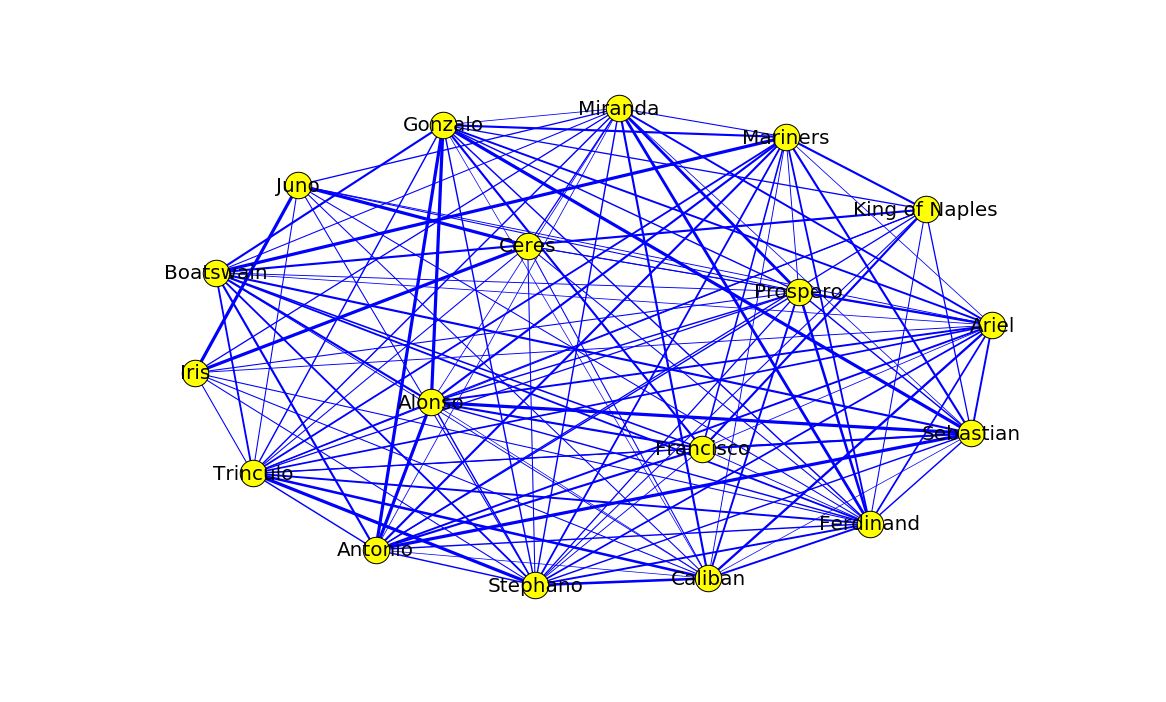

In [101]:
try:
    import matplotlib.pyplot as plt
except:
    raise

import networkx as nx
%matplotlib inline
plt.figure(figsize=(20, 12))
matplotlib.rcParams['figure.figsize']
G_nx=nx.Graph()

for pair in dict_ji.keys():
    G_nx.add_edge(pair[0], pair[1])

pos=nx.spring_layout(G_nx, k=0.8) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G_nx,pos,node_size=700, node_color ='yellow')

# edges
for i in range(len(dict_ji.keys())):
    test_list = []
    test_list.append(dict_ji.keys()[i])
    nx.draw_networkx_edges(G_nx, pos, edgelist = test_list, width = arr_normalized[i], edge_color='blue')

# labels
nx.draw_networkx_labels(G_nx,pos,font_size=20,font_color = 'k', font_family='sans-serif')

plt.axis('off')

plt.show()  

Let's see how different the network graph may be for Adamic and Adar.

In [102]:
dict_ad = adamic_adar(G_t.edges_events, G_t.events)
list_ad_values = dict_ad.values()
arr_normalized_ad = np.array(list_ad_values)*3.0
#print arr_normalized_ad

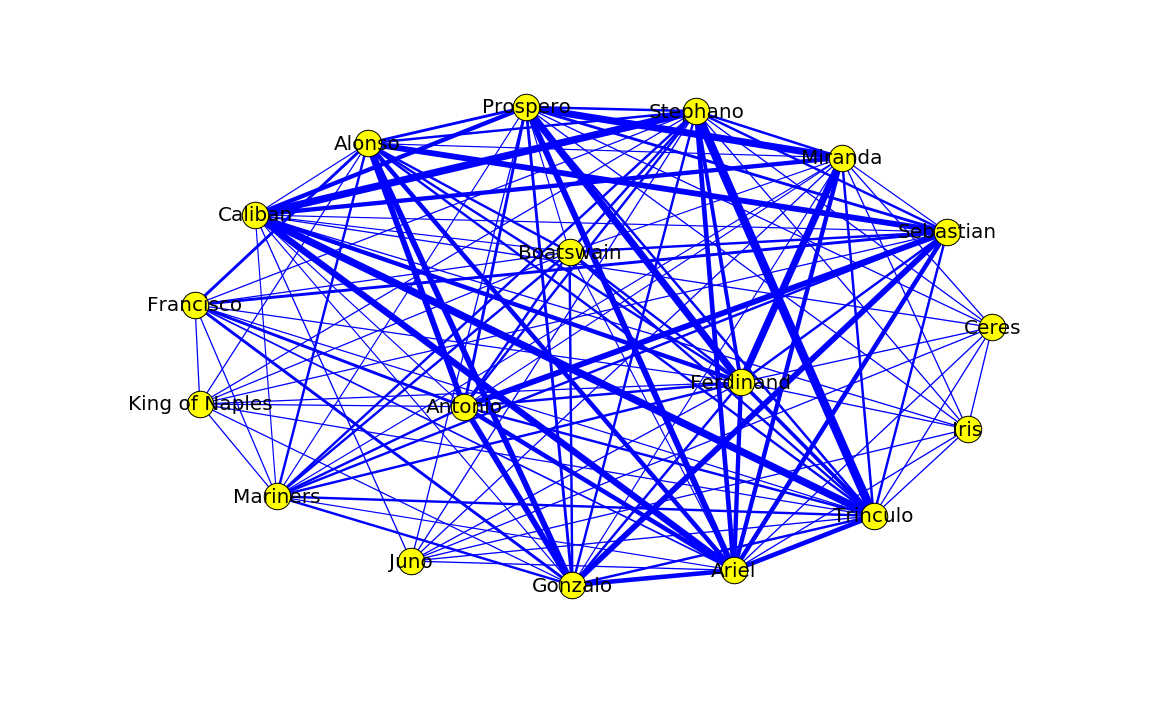

In [105]:
%matplotlib inline
plt.figure(figsize=(20, 12))
matplotlib.rcParams['figure.figsize']
G_ad=nx.Graph()

for pair in dict_ad.keys():
    G_ad.add_edge(pair[0], pair[1])

pos=nx.spring_layout(G_ad, k=0.8) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G_ad,pos,node_size=700, node_color ='yellow')

# edges
for i in range(len(dict_ad.keys())):
    test_list = []
    test_list.append(dict_ad.keys()[i])
    nx.draw_networkx_edges(G_ad, pos, edgelist = test_list, width = arr_normalized_ad[i], edge_color='blue')


# labels
nx.draw_networkx_labels(G_ad,pos,font_size=20,font_color = 'k', font_family='sans-serif')

plt.axis('off')

plt.show() 

We can see some noticeable differences in the two graphs.  For example, Iris, Juno and Ceres which are three spirits that only occurred in one scene in _the Tempest_ are weighted much heavier in Jaccard Index than Adamic and Adar based on the thickness of the edges.  This is because jaccard index takes into consideration of all many events two individuals attended together out of the union set of events they attend.  Iris, Juno and Ceres only occurred once and the only scene they were in they were together, so it makes sense for the three minor characters to have strong ties in Jaccard Index.  On the other hand, Adamic and Adar’s tie strength increases with the number of events.  Iris, Juno and Ceres only occurred in one scene, so it makes sense for the three of to have low weights.  

by: Luan Jiang

References:

Grupe, Mangesh, Eliassi-Rad, Tina. Measuring Tie Strength in Implicit Social Networks. Retrieved from  http://eliassi.org/papers/gupte-websci12.pdf

Link Prediction Algorithms. Retrieved from http://be.amazd.com/link-prediction/

Weighted Graph. Retrieved from https://networkx.github.io/documentation/networkx-1.10/examples/drawing/weighted_graph.html

The Tempest Summary. Retrieved from http://www.sparknotes.com/shakespeare/tempest/section10.rhtml 
